In [355]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications import VGG16

import os
import numpy as np
import matplotlib.pyplot as plt

In [356]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [357]:
base = 'cats_and_dogs'

In [358]:
train_images = os.path.join(base, 'train')
validation_images = os.path.join(base, 'validation')

In [359]:
train_images_cats = os.path.join(train_images, 'cats')
train_images_dogs = os.path.join(train_images, 'dogs')
validation_images_cats = os.path.join(validation_images, 'cats')
validation_images_dogs = os.path.join(validation_images, 'dogs')

In [360]:
num_cats_tr = len(os.listdir(train_images_cats))
num_dogs_tr = len(os.listdir(train_images_dogs))
num_cats_val = len(os.listdir(validation_images_cats))
num_dogs_val = len(os.listdir(validation_images_dogs))

In [361]:
total_train = num_cats_tr + num_dogs_tr
total_validation = num_cats_val + num_dogs_val

In [362]:
BATCH_SIZE = 32
IMG_SHAPE = 150

In [363]:
#feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
#pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model,
#                                                    input_shape=(IMG_SHAPE,IMG_SHAPE,3),
#                                                    trainable=False)

In [364]:
conv_base = VGG16(weights='imagenet', include_top=False,
                  input_shape=(IMG_SHAPE,IMG_SHAPE,3))
conv_base.trainable = False

In [365]:
train_images_generator = ImageDataGenerator(rescale=1./255, #rescalar
                                            rotation_range=40, #rotacionar imagem
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            shear_range=0.2, #cisalhamento
                                            zoom_range=0.2, #zoom
                                            horizontal_flip=True, #inverter horizontalmente
                                            fill_mode='nearest')


validation_images_generator = ImageDataGenerator(rescale=1./255)


In [366]:
train_data_gen = train_images_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                            directory=train_images,
                                                            shuffle=True,
                                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                                            class_mode='binary'
                                                           )

validation_data_gen = train_images_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                            directory=validation_images,
                                                            shuffle=False,
                                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                                            class_mode='binary'
                                                           )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [367]:
train_data_gen.class_indices

{'cats': 0, 'dogs': 1}

In [368]:
validation_data_gen.class_indices

{'cats': 0, 'dogs': 1}

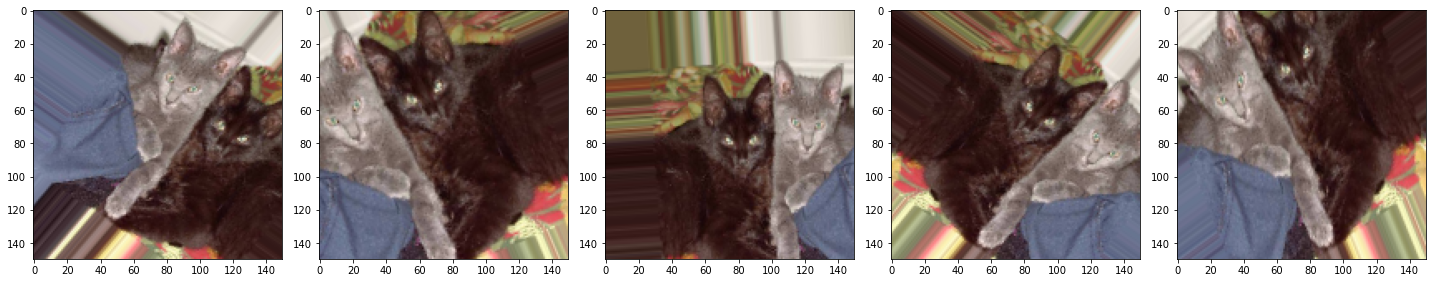

In [369]:
images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(images)

In [370]:
model = keras.models.Sequential([
    conv_base,
    
    keras.layers.GlobalAveragePooling2D(),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),

    keras.layers.Dense(2, activation='softmax')
                         
])

In [371]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [372]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 2050      
Total params: 15,242,050
Trainable params: 527,362
Non-trainable params: 14,714,688
_________________________________________________________________


In [373]:
EPOCHS = 5

In [ ]:
history = model.fit_generator(train_data_gen, 
                              steps_per_epoch = int(np.ceil(total_train / float(BATCH_SIZE))),
                              epochs=EPOCHS,
                              validation_data=validation_data_gen, 
                              validation_steps = int(np.ceil(total_validation / float(BATCH_SIZE)))
                              )

Epoch 1/5
52/63 [=======================>......] - ETA: 17s - loss: 0.5238 - accuracy: 0.7324

In [ ]:
model.save("cats_and_dogs_modelTL.h5")

In [ ]:
# analysis
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#fazer predições
test_images = os.path.join(base, 'test')
test_dogs_images = os.path.join(test_images, 'dogs')
test_cats_images = os.path.join(test_images, 'cats')

In [ ]:
os.listdir(test_images)

In [ ]:
contCorretos = 0
for i in os.listdir(test_dogs_images):
    patch_image = os.path.join(test_dogs_images, i)
    test_data_gen = image.load_img(patch_image, target_size=(IMG_SHAPE,IMG_SHAPE))
    
    img_array = image.img_to_array(test_data_gen)
    img_batch = np.expand_dims(img_array, axis=0)
    
    img_preprocessed = preprocess_input(img_batch)
    
    prediction = model.predict(img_preprocessed)
    #print(np.around(prediction))
    
    if np.around(prediction[0][1]) == 1.:
        contCorretos += 1

In [ ]:
prediction[0][1].dtype

In [ ]:
acertos = contCorretos/len(os.listdir(test_dogs_images))
print("Taxa de acerto dos dogs:", acertos)

In [ ]:
len(os.listdir(test_dogs_images))

In [ ]:
contCorretosCats = 0
for i in os.listdir(test_cats_images):
    patch_image = os.path.join(test_cats_images, i)
    test_data_gen = image.load_img(patch_image, target_size=(IMG_SHAPE,IMG_SHAPE))
    
    img_array = image.img_to_array(test_data_gen)
    img_batch = np.expand_dims(img_array, axis=0)
    
    img_preprocessed = preprocess_input(img_batch)
    
    prediction = model.predict(img_preprocessed)
    #print(np.around(prediction))
    
    if np.around(prediction[0][0]) == 1.:
        contCorretosCats += 1

In [ ]:
acertosCats = contCorretosCats/len(os.listdir(test_cats_images))
print("Taxa de acerto dos cats:", acertosCats)

In [ ]:
print("Taxa de acertos total:", (contCorretosCats+contCorretos)/(len(os.listdir(test_cats_images))+len(os.listdir(test_dogs_images))))

In [ ]:
prediction[0]